**EE641 Final Project**

Class: EE641 – Deep Learning Systems Topic: Plant Disease Detection Team: Kaisen Ye, Reshma Nawaz

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Residual Block Definition
class ResidualBlock(Model):
    def __init__(self, filters, kernel_size, strides=1, downsample=False):
        super(ResidualBlock, self).__init__()
        self.downsample = downsample

        # Main path
        self.conv1 = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal')
        self.bn2 = layers.BatchNormalization()

        # Shortcut path
        if self.downsample:
            self.shortcut = tf.keras.Sequential([
                layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal'),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

    def call(self, inputs):
        shortcut = self.shortcut(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        return self.relu(x + shortcut)


# ResNet50 Model Definition
class ResNet50(Model):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()

        self.conv1 = layers.Conv2D(64, 7, strides=2, padding='same', kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.maxpool = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        # Residual blocks
        self.layer1 = self._build_residual_layer(64, 3, strides=1)
        self.layer2 = self._build_residual_layer(128, 4, strides=2)
        self.layer3 = self._build_residual_layer(256, 6, strides=2)
        self.layer4 = self._build_residual_layer(512, 3, strides=2)

        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def _build_residual_layer(self, filters, blocks, strides):
        layers_list = [ResidualBlock(filters, kernel_size=3, strides=strides, downsample=True)]
        for _ in range(1, blocks):
            layers_list.append(ResidualBlock(filters, kernel_size=3))
        return tf.keras.Sequential(layers_list)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        return self.fc(x)

In [3]:
# Dataset Preparation
data_dir = "/kaggle/input/plant-disease-recognition-dataset"
image_size = 224

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dataset = train_datagen.flow_from_directory(
    f'{data_dir}/Train/Train',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='sparse'
)
val_dataset = val_datagen.flow_from_directory(
    f'{data_dir}/Validation/Validation',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='sparse'
)
test_dataset = test_datagen.flow_from_directory(
    f'{data_dir}/Test/Test',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='sparse'
)

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [4]:
# Compile and Train the Model
num_classes = 3  # Adjust based on your dataset
model = ResNet50(num_classes)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,  # Starting learning rate
    decay_steps=1000,           # Number of steps to decay
    decay_rate=0.96,            # Multiplicative factor of learning rate decay
    staircase=True              # Decay in discrete intervals
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [5]:
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733951386.995010      85 service.cc:145] XLA service 0x7d8b4c001df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733951386.995066      85 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/42 ━━━━━━━━━━━━━━━━━━━━ 34:34 51s/step - accuracy: 0.2812 - loss: 388.2906

I0000 00:00:1733951399.564974      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.3133 - loss: 178.1672 - val_accuracy: 0.3333 - val_loss: 1.1033
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3952 - loss: 1.0602 - val_accuracy: 0.4833 - val_loss: 0.9171
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5857 - loss: 0.8372 - val_accuracy: 0.5167 - val_loss: 0.8547
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6417 - loss: 0.7309 - val_accuracy: 0.6333 - val_loss: 0.7560
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6082 - loss: 0.7695 - val_accuracy: 0.5833 - val_loss: 0.7890
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6896 - loss: 0.6353 - val_accuracy: 0.7000 - val_loss: 0.7159
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7358 - loss: 0.6229 - val_accuracy: 0.6500 - val_loss: 0.7134
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7142 - loss: 0.6366 - val_accuracy: 0.7167 - val_loss: 0.6580


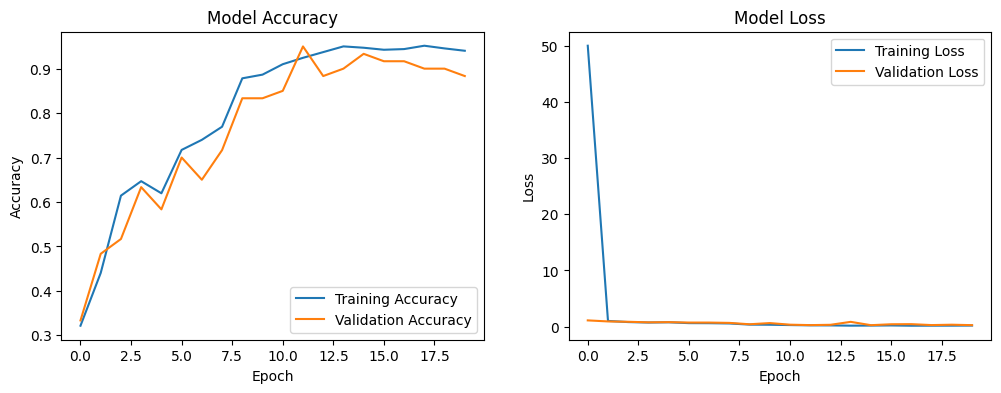

In [6]:
import matplotlib.pyplot as plt
# Plot training results
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Evaluate on Test Dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8963 - loss: 0.2380
Test Loss: 0.23540489375591278
Test Accuracy: 0.8933333158493042


In [8]:
# Save the model
model.save('/kaggle/working/resnet50_plant_disease_model_from_scratch.h5')